In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
class RLnetwork:
    def __init__(self, f, g, I_):
        self.f = f
        self.g = g
        self.I_ = np.array([I_, -I_, 0, 0])
        self.Wa = np.ones(9)
        self.Wc = np.ones(9)
        self.Gamma = np.eye(9, dtype=int)*10
        
        self.v = 1
        self.G = 100
        self.R = 1
        self.b = 1
        self.nc1 = 1
        self.nc2 = 1
        self.na1 = 10
        self.na2 = 1
        
        
    def equation(self, x, u):
        return self.f(x) + self.g(x) * u
    
    @staticmethod
    def sigma(x):
        return np.array([
            x[0]**2,
            x[0]*x[1],
            x[1]**2,
            np.sin(x[2]),
            np.sin(x[3]),
            np.cos(x[2]),
            np.cos(x[3]),
            np.sin(x[3]-x[2]),
            np.cos(x[3]-x[2])
        ])
    
    @staticmethod
    def grad_sigma(x):
        ds = np.empty((9,4))
        ds[0] = np.array([2*x[0], 0, 0, 0])
        ds[1] = np.array([x[1], x[0], 0, 0])
        ds[2] = np.array([0, 2*x[1], 0, 0])
        ds[3] = np.array([0, 0, np.cos(x[2]), 0])
        ds[4] = np.array([0, 0, 0, np.cos(x[3])])
        ds[5] = np.array([0, 0, -np.sin(x[2]), 0])
        ds[6] = np.array([0, 0, 0, -np.sin(x[3])])
        ds[7] = np.array([0, 0, -np.cos(x[3]-x[2]), np.cos(x[3]-x[2])])    
        ds[8] = np.array([0, 0, np.sin(x[3]-x[2]), -np.sin(x[3]-x[2])])
        return ds
    
    def sigmaG(self, x):
        gs = self.grad_sigma(x-self.I_)
        g = self.g(x)[:, None]
        return (1/self.R) * (gs @ g @ g.T @ gs.T) 
    
    def r(self, x, u):
        return (1/2)* (x[0])**2 + self.R*(u**2)
    
    def V(self, x):
        return self.W_c @ self.sigma(x-self.I_)
    
    def u(self, x):
        gs = self.grad_sigma(x-self.I_)
        return - (1/2) * (1/self.R) * (self.g(x)@ (gs.T @ self.Wa))
    
    def delta(self, x):
        u = self.u(x)
        return (self.Wc[:, None].T @ self.grad_sigma(x-self.I_)) @ self.equation(x, u) + self.r(x-self.I_, u)
    
    @staticmethod
    def generate_x(x, N=10):
        perturbation = np.random.uniform(-1, 1, N)
        x_set = np.vstack([perturbation, -perturbation, np.zeros((2, N))]).T + x
        return x_set
    
    
    def w(self, x):
        xdot = self.equation(x, self.u(x))
        gs = self.grad_sigma(x-self.I_)
        return gs@xdot
    
    def p(self, w):
        return 1 + self.v * (w[:, None].T @ self.Gamma @ w)
    
    def upd_Wc(self, x, x_set, dt=0.1):
        w = self.w(x)
        w1 = -self.nc1*self.delta(x)* (self.Gamma @ w) / self.p(w)
        
        si = []
        for xi in x_set:
            _wi = self.w(xi)
            _pi = self.p(_wi)
            _deltai = self.delta(xi)
            si.append(_deltai*_wi/_pi)
        s = np.sum(si, axis=0)/len(x_set)
        w2 = -self.nc2* (self.Gamma @ s)
        
        self.Wc = self.Wc + (w1+w2)*dt
        
    def upd_Gamma(self, x, dt=0.1):
        w = self.w(x)
        p = self.p(w)
        g = - self.nc1*(self.Gamma@w[:,None])@(w[:,None].T@self.Gamma)/(p**2)
        
        gamma = self.b*self.Gamma + g
        self.Gamma = gamma*(np.linalg.norm(gamma)<self.G)
        
    def upd_Wa(self, x, x_set, dt=0.1):
        w = self.w(x)
        p = self.p(w)
        sigmaG = self.sigmaG(x)
        
        w1 = - self.na1 * (self.Wa - self.Wc)
        
        w2 = - self.na2 * self.Wa
        
        w3 = (self.nc1/(4*p)) * (sigmaG.T @ self.Wa[:, None] @ w[:, None].T @ self.Wc)
        
        si = []
        for xi in x_set:
            _wi = self.w(xi)
            _pi = self.p(_wi)
            _sigmaGi = self.sigmaG(xi)
            si.append((_sigmaGi.T @ self.Wa[:, None] @ _wi[:, None].T)/_pi)
        s = np.sum(si, axis=0)/len(x_set)
        w4 = (self.nc2/4) *(s @ self.Wc)
        
        self.Wa = self.Wa + (w1+w2+w3+w4)*dt
    
    def optimize(self, x):
        x_set = self.generate_x(x)
        
        self.upd_Gamma(x)
        self.upd_Wc(x, x_set)
        self.upd_Wa(x, x_set)
        return self.u(x)
        

In [81]:
from models import Model1

In [82]:
m1 = Model1(np.array([6, 4, 0, 0]))
net = RLnetwork(m1.f, m1.g, 8)
u = net.u(m1.state)

for i in range(990):
    m1.update(u)
    u = net.optimize(m1.state)
    print(u) if i%100==0 else _

-2.3938172829127593
0.06760010610413802
0.0005588399128343413
0.06863668067924067
0.007695745341941951
-0.028526284040654826
-0.0022505688026726034
0.0024646470811955368
0.00810584571540307
-0.01002827022395758
-0.011752823203873941
-0.0046847930178604
-0.0007955566938772363
0.010983257911954869
0.016676919744850416
0.011567106649192027
0.01136051817186745
0.0100582677537715
0.0059491993417686295
0.005502549747735008


In [83]:
m1.state

array([   8.03808734,    1.96191266, 1648.12335693, 1502.3354681 ])

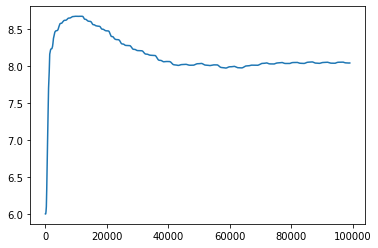

In [84]:
X = m1.evolution
plt.plot(X[:,0])

In [85]:
net.Wc.round(2), net.Wa.round(2)

(array([ 0.98,  1.21,  0.61,  0.  ,  0.  , -0.  ,  0.  ,  0.57,  0.54]),
 array([ 0.89,  1.1 ,  0.55,  0.  ,  0.  , -0.  ,  0.  ,  0.52,  0.49]))